# NYC fare prediction

[This notebook](TBD) shows my approach for predicting the fare amount for a taxi ride in NYC when given the pickup and dropoff locations of the passangers regarding the [New York City Taxi Fare Prediction Challange]( https://www.kaggle.com/c/new-york-city-taxi-fare-prediction).



---

This notebook is seperated into different sections, relating to the common data science workflow (except the hypothesis and data collection where already done).


0.   Previous Commits
1.   Setup and Check Infrastructure
2.   Having a first look at the Data (EDA)
3.   Data Cleaning (Feature Engineering)
4.   Linear Regression
5.   Ridge Regression
6.   Model ...
7.   Evaulation and Discussion

---



# 0. Previous Commits - Comparison of different Models:



Predictions are done when using the whole data set

### Linear Regression

**Commit 1 (Baseline) Score: 5.67093**
- 5.67093
 

### Ridge Regression

**Commit 2 Score: 12.54277**

params_ridge
  - alpha = loguniform(1e-5, 1e0)
  - solver = ['eig', 'cd']
  - n_iter = 100
  - cv = 5
  - verbose = 0
  - n_jobs = 1

ridge_params
  - alpha = 0.240960447726532
  - fit_intercept = True
  - normalize = False
  - solver = 'eig'

RMSE for Ridge_rmse Regression is  -7.212150573730469


### K-Nearest Neighbor 
**Commit 3 Score: 4.86790**
  - n_neighbors = 4
  - data_size = 5.5 Mio rows (1 %)

### Random Forest 
**Commit 4 Score: 5.95518**
  - n_estimators=10
  - n_jobs=-1
  - data_size = 1 Mio. rows



# 1. Setup and Check Infrastructure

Check for GPU

In [1]:
!nvidia-smi

Mon Sep 21 12:56:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install RAPIDS and Dask_ml
!pip install dask_ml
!pip install dask_cuda

!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable


import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh s'
                  '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.15, or '!bash rapidsai-csp-utils/colab/rapids-colab.sh nightly', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh n'
Enjoy using RAPIDS!  

In [4]:
import nvstrings
import numpy as np
import cudf, cuml
import dask_cudf
import io, requests
import math
import gc
import cupy as cp
import pandas as pd

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

#Learning
from cuml.preprocessing.model_selection import train_test_split
from scipy.stats import uniform

# Linear Models https://github.com/rapidsai/cuml/tree/branch-0.13/notebooks
from cuml.linear_model import LinearRegression # Linear
from cuml.linear_model import LogisticRegression # Logisitc
from cuml.linear_model import ElasticNet # Elastic
from cuml.linear_model import Ridge # Ridge
from cuml.linear_model import Lasso # Lasso
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor # Mini Batch SGD Regressor

from cuml.solvers import SGD as cumlSGD # Stochastic Gradient Descent
from cuml.ensemble import RandomForestRegressor as cuRF # Random Forest
from cuml.dask.ensemble import RandomForestClassifier as cumlDaskRF # RandomForest

from cuml.neighbors import KNeighborsRegressor as cumlKNR # Nearest Neighbours
from cuml.svm import SVC # Support Vector Machines

from cuml import ForestInference
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from cuml.metrics.regression import r2_score
from cuml.metrics.accuracy import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score as sk_acc
from sklearn.utils.fixes import loguniform

ModuleNotFoundError: ignored

If you find yourself running these notebooks on Colab as well as on Kaggle you might find this placeholder thing helpful. Only thing to touch ist the environment you are running on (Kaggle or Colab)

In [8]:
## Switch from Kaggle 
environment='Kaggle'

if environment == 'Kaggle':
  env_submission_path='./'
  env_path='../input/new-york-city-taxi-fare-prediction/'
  print('The paths were successfully setup for Kaggle')
elif environment == 'Colab':
  env_submission_path='/content/drive/My Drive/Colab Notebooks/'
  env_path='/content/drive/My Drive/Colab Notebooks/'

  from google.colab import drive
  drive.mount('/content/drive')

  print('The paths were successfully setup for Colab')

else:
  print('Something went wrong here, please choose one of the options for path completion: Kaggle or Colab (or implement your own thing)')


The paths were successfully setup for Kaggle


# 2. First look at the Data

In [ ]:
cudf.set_allocator("managed")
dtype = {'fare_amount': 'float32',
              'pickup_datetime':'str',
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'int8'}

usecols = list(dtype.keys())

In [ ]:
%%time
# use a subset with 50.000 rows, max is nrows = 55423480
## using 1%
nrows = 1042348

test = cudf.read_csv(env_path+'test_taxi.csv', nrows=nrows, usecols=usecols, dtype=dtype)
train = cudf.read_csv(env_path+'train.csv', nrows=nrows, usecols=usecols, dtype=dtype)
submission = cudf.read_csv(env_path+'sample_submission.csv', usecols=usecols, dtype=dtype)

CPU times: user 858 ms, sys: 539 ms, total: 1.4 s
Wall time: 1.5 s


In [ ]:
train.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844307,40.721321,-73.841614,40.712273,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982742,40.761269,-73.991234,40.750565,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987137,40.733139,-73.991570,40.758095,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968102,40.768009,-73.956665,40.783768,1


In [ ]:
test.head(5)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739197,1
2,2011-10-08 11:53:44 UTC,-73.982536,40.751259,-73.979668,40.746140,1
3,2012-12-01 21:12:12 UTC,-73.981163,40.767811,-73.990440,40.751633,1
4,2012-12-01 21:12:12 UTC,-73.966042,40.789776,-73.988579,40.744431,1


# 3. Data Cleaning

In [ ]:
#Drop Nan Values
train.nans_to_nulls()
train = train.dropna()

In [ ]:
#Checking shape of the data
print("Train: " + str(train.shape))
print("Test: " + str(test.shape))

Train: (1042338, 7)
Test: (9914, 6)


In [ ]:
#Changing the data format of pickup_datetime and adding additional information about pickup time
train['pickup_datetime'] = train['pickup_datetime'].astype('datetime64[ns]')

train["hour"] = train.pickup_datetime.dt.hour
train["weekday"] = train.pickup_datetime.dt.weekday
train["month"] = train.pickup_datetime.dt.month
train["year"] = train.pickup_datetime.dt.year


test['pickup_datetime'] = test['pickup_datetime'].astype('datetime64[ns]')

test["hour"] = test.pickup_datetime.dt.hour
test["weekday"] = test.pickup_datetime.dt.weekday
test["month"] = test.pickup_datetime.dt.month
test["year"] = test.pickup_datetime.dt.year

In [ ]:
#calculate trip distance in miles
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [ ]:
train['distance'] = distance(train['pickup_latitude'], train['pickup_longitude'], train['dropoff_latitude'], train['dropoff_longitude'] )
test['distance'] = distance(test['pickup_latitude'], test['pickup_longitude'], test['dropoff_latitude'], test['dropoff_longitude'] )
train['distance'].describe()

count    1.042338e+06
mean     1.166205e+01
std      2.252111e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.366828e+00
75%      2.367415e+00
max      1.048769e+04
Name: distance, dtype: float64

In [ ]:
#check if everything worked
train.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397
2,5.7,2011-08-18 00:35:00,-73.982742,40.761269,-73.991234,40.750565,2,0,3,8,2011,0.000000
3,7.7,2012-04-21 04:30:42,-73.987137,40.733139,-73.991570,40.758095,1,4,5,4,2012,1.932986
4,5.3,2010-03-09 07:51:00,-73.968102,40.768009,-73.956665,40.783768,1,7,1,3,2010,1.366828
5,12.1,2011-01-06 09:50:45,-74.000969,40.731628,-73.972893,40.758232,1,9,3,1,2011,2.425102
6,7.5,2012-11-20 20:35:00,-73.980003,40.751663,-73.973801,40.764847,1,20,1,11,2012,0.000000
7,16.5,2012-01-04 17:22:00,-73.951302,40.774139,-73.990097,40.751045,1,17,2,1,2012,2.480990
8,9.0,2012-12-03 13:10:00,-74.006454,40.726719,-73.993073,40.731625,1,13,0,12,2012,0.000000
9,8.9,2009-09-02 01:11:00,-73.980667,40.733871,-73.991539,40.758137,2,1,2,9,2009,1.932986


In [ ]:
test.head(2)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,1.366828
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739197,1,13,1,1,2015,1.366828


In [ ]:
print("Ararage fare amount: " + str(train['fare_amount'].mean()))
print("Standard deviation fare amount: " + str(train['fare_amount'].std()))
print("Ararage distance: " + str(train['distance'].mean()) + " miles")
print("Standard deviation distance: " + str(train['distance'].std()) + " miles")

Ararage fare amount: 11.344459746938186
Standard deviation fare amount: 9.818480022306119
Ararage distance: 11.662054041372972 miles
Standard deviation distance: 225.2111130194817 miles


In [ ]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
count,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06,1.042338e+06
mean,1.134446e+01,-7.252647e+01,3.993093e+01,-7.252710e+01,3.992477e+01,1.684628e+00,1.350942e+01,3.039528e+00,6.267507e+00,2.011741e+03,1.166205e+01
std,9.818480e+00,1.199978e+01,7.734151e+00,1.141861e+01,8.542040e+00,1.308595e+00,6.513691e+00,1.949922e+00,3.436094e+00,1.860606e+00,2.252111e+02
min,-4.490000e+01,-3.377681e+03,-3.116285e+03,-3.383297e+03,-3.114339e+03,-4.800000e+01,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03,0.000000e+00
25%,6.000000e+00,-7.399206e+01,4.073497e+01,-7.399138e+01,4.073407e+01,1.000000e+00,9.000000e+00,1.000000e+00,3.000000e+00,2.010000e+03,0.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075267e+01,-7.398014e+01,4.075317e+01,1.000000e+00,1.400000e+01,3.000000e+00,6.000000e+00,2.012000e+03,1.366828e+00
75%,1.250000e+01,-7.396711e+01,4.076715e+01,-7.396367e+01,4.076813e+01,2.000000e+00,1.900000e+01,5.000000e+00,9.000000e+00,2.013000e+03,2.367415e+00
max,5.000000e+02,2.522271e+03,2.621629e+03,1.717003e+03,1.989728e+03,9.000000e+00,2.300000e+01,6.000000e+00,1.200000e+01,2.015000e+03,1.048769e+04


Visualization of the data <br>

The following things were noticed (while using 500k datapoints):
*   The minimal fare_amount is negative. As this does not seem to be realistic I will drop them from the dataset.
*   Some of the minimum and maximum longitude/lattitude coordinates are way off. These  will also be remove from the dataset. (bounding box will be defined)
*   The average fare_amount is about 9.79 USD with a standard deviation of 7.48 USD. When building a predictive model we want to be better than 7.48 USD.



In [ ]:
train = train[train.fare_amount>=0]
train = train[(train['distance'] < 30) & (train['distance'] >=0 )]

In [ ]:
fare_amount = train['fare_amount'].to_array()
passenger_count = train['passenger_count'].to_array()
distance = train['distance'].to_array()

Text(0.5, 1.0, 'Verteilung des Fahrpreises')

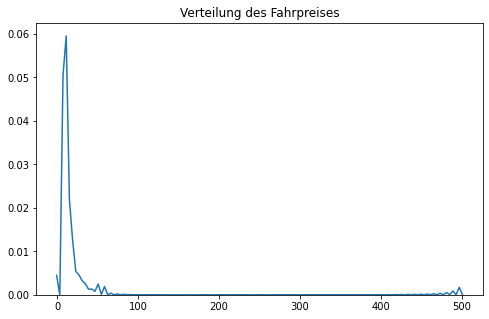

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(fare_amount).set_title("Verteilung des Fahrpreises")

Text(0.5, 1.0, 'Distanz')

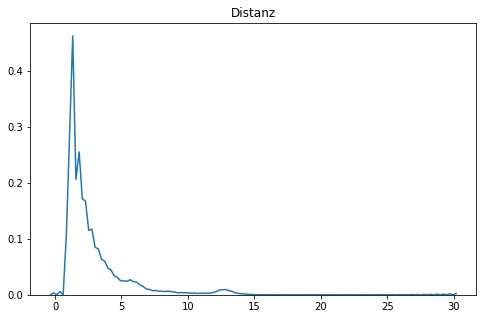

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(distance).set_title("Distanz")

In [ ]:
#check max latitude und max longitude of test data
print("Max lat pickup: " + str(test['pickup_latitude'].max()))
print("Max lat dropoff: " + str(test['dropoff_latitude'].max()))
print("Max lon pickup: " + str(test['pickup_longitude'].max()))
print("Max lon dropoff: " + str(test['dropoff_longitude'].max()))
print("")
print("Min lat pickup: " + str(test['pickup_latitude'].min()))
print("Min lat dropoff: " + str(test['dropoff_latitude'].min()))
print("Min lon pickup: " + str(test['pickup_longitude'].min()))
print("Min lon dropoff: " + str(test['dropoff_longitude'].min()))

Max lat pickup: 41.709553
Max lat dropoff: 41.696682
Max lon pickup: -72.986534
Max lon dropoff: -72.99096

Min lat pickup: 40.57314
Min lat dropoff: 40.568974
Min lon pickup: -74.25219
Min lon dropoff: -74.26323


Bounding Box New York
<table>
  <tr>
    <th></th>
    <th>Dropoff</th>
    <th>Pickup</th>
  </tr>
  <tr>
    <td>Max Long</td>
    <td>-72.99096</td>
    <td>-72.986534</td>
   </tr>
   <tr>
    <td>Max Lat</td>
    <td>41.696682</td>
    <td>41.709553</td>
   </tr>
   <tr>
    <td>Min Long</td>
    <td>-74.26323</td>
    <td>-74.25219</td>
    </tr>
   <tr>
    <td>Min Lat</td>
    <td>40.568974</td>
    <td>40.57314</td>
   </tr>
</table>



In [ ]:
train.head(2)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,weekday,month,year,distance
0,4.5,2009-06-15 17:26:21,-73.844307,40.721321,-73.841614,40.712273,1,17,0,6,2009,0.000000
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1,16,1,1,2010,5.244397


In [ ]:
#Parts of train data are too far away, so they can be dropped
train = train[(train['pickup_longitude'] > -74.25) & (train['pickup_longitude'] < -72.98)]
train = train[(train['pickup_latitude'] > 40.57) & (train['pickup_latitude'] < 41.70)]
train = train[(train['dropoff_longitude'] < -72.99) & (train['dropoff_longitude'] > -74.26)]
train = train[(train['dropoff_latitude'] > 40.56) & (train['dropoff_latitude'] < 41.69)]

(-74.03, -73.75)

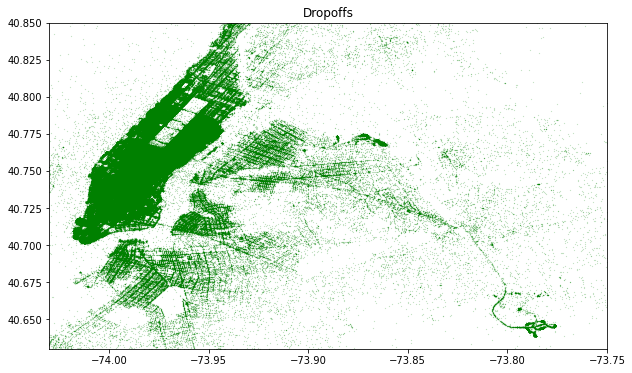

In [ ]:
dropoff_longitude = train['dropoff_longitude'].to_array()
dropoff_latitude = train['dropoff_latitude'].to_array()

city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

plt.figure(figsize=(10,6))
plt.scatter(dropoff_longitude, dropoff_latitude,
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [ ]:
unnecessary_columns=['pickup_datetime','dropoff_latitude','pickup_latitude','dropoff_longitude','pickup_longitude']
train=train.drop(unnecessary_columns,axis=1)
test=test.drop(unnecessary_columns,axis=1)

In [ ]:
train.head(2)

,fare_amount,passenger_count,hour,weekday,month,year,distance
0,4.5,1,17,0,6,2009,0.000000
1,16.9,1,16,1,1,2010,5.244397


In [ ]:
test.head(2)

,passenger_count,hour,weekday,month,year,distance
0,1,13,1,1,2015,1.366828
1,1,13,1,1,2015,1.366828


# 4. Linear Regression

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  4338063
Number of records in validation data  1084515
(4338063, 6)
(1084515, 6)
(4338063,)
(1084515,)


In [ ]:
lm = LinearRegression(fit_intercept = True, normalize = False,
                      algorithm = "eig")
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse = r2_score(y_pred, y_test)
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  0.6513239145278931


In [ ]:
y_pred=lm.predict(test)
y_pred

0       11.075806
1       11.075806
2        4.637329
3       10.121460
4       16.556641
          ...    
9909    11.159302
9910    14.171509
9911    47.609009
9912    24.075684
9913     6.169189
Length: 9914, dtype: float32

In [ ]:
gdf_submission = submission
gdf_submission['fare_amount']= y_pred

gdf_submission.head()

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.075806
1,2015-01-27 13:08:24.0000003,11.075806
2,2011-10-08 11:53:44.0000002,4.637329
3,2012-12-01 21:12:12.0000002,10.121460
4,2012-12-01 21:12:12.0000003,16.556641


In [ ]:
gdf_submission.to_csv(env_submission_path+'submission_LinearReg.csv',index=False)

# 5. Ridge Regression

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  4338063
Number of records in validation data  1084515
(4338063, 6)
(1084515, 6)
(4338063,)
(1084515,)


In [ ]:
params_ridge = {
    "alpha": loguniform(1e-5, 1e0), # default 1.0
    "solver": ['eig', 'cd'], 
}
ridge = Ridge()
clf = RandomizedSearchCV(ridge, params_ridge, random_state=1, n_iter=100, cv=5, verbose=0, n_jobs=1)
best_model = clf.fit(X_train,y_train)

RuntimeError: ignored

In [ ]:
best_model.best_estimator_.get_params()

In [ ]:
ridge_params = {
 'alpha': 0.240960447726532,
 'fit_intercept': True,
 'normalize': False,
 'solver': 'eig'
}

ridge = Ridge(**ridge_params)
result_ridge = ridge.fit(X_train,y_train)

y_pred = result_ridge.predict(X_test)
ridge_rmse = r2_score(y_pred, y_test)
print("RMSE for Ridge_rmse Regression is ", ridge_rmse)

In [ ]:
ridge_pred = result_ridge.predict(test)

In [ ]:
gdf_submission = submission
gdf_submission['fare_amount']= ridge_pred

gdf_submission.head()

In [ ]:
gdf_submission.to_csv(env_submission_path+'submission_RidReg.csv',index=False)

# 6. K-Nearest Neighbors Regression

https://github.com/rapidsai/cuml/blob/branch-0.13/notebooks/kneighbors_regressor_demo.ipynb


In [ ]:
## params
n_neighbors=4

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  4338063
Number of records in validation data  1084515
(4338063, 6)
(1084515, 6)
(4338063,)
(1084515,)


In [ ]:
## inspiration: https://www.kaggle.com/cdeotte/rapids-knn-30-seconds-0-938/notebook

%%time
knn_cuml = cumlKNR(n_neighbors=n_neighbors)
knn_cuml.fit(X_train, y_train)

cuml_result = knn_cuml.predict(test)

CPU times: user 1.19 s, sys: 847 ms, total: 2.03 s
Wall time: 2.04 s


In [ ]:
#y_pred=knn_cuml.predict(X_test)

y_pred = knn_cuml.predict(X_test)
knn_cuml_rmse = cuml.metrics.regression.r2_score(y_pred, y_test)
print("RMSE for K-Nearest Neighbor is ",knn_cuml_rmse)

RMSE for K-Nearest Neighbor is  0.6598584651947021


In [ ]:
gdf_submission = submission
gdf_submission['fare_amount']= cuml_result

gdf_submission.head()

gdf_submission.to_csv(env_submission_path+'submission_KNearest.csv',index=False)

# Random Forest GPU


In [ ]:
## params
n_estimators=10
n_jobs=-1

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Number of records in training data  816084
Number of records in validation data  204020
(816084, 6)
(204020, 6)
(816084,)
(204020,)


In [ ]:
%%time
rf_cuml = cuRF(n_estimators=n_estimators)
rf_cuml.fit(X_train, y_train)

cuRF_result = rf_cuml.predict(test)

CPU times: user 934 ms, sys: 531 ms, total: 1.47 s
Wall time: 1 s


In [ ]:
y_pred = rf_cuml.predict(X_test)
rf_cuml_rmse = cuml.metrics.regression.r2_score(y_pred, y_test)
print("RMSE for Random Forest is ",rf_cuml_rmse)

RMSE for Random Forest is  0.24728357791900635


In [ ]:
gdf_submission = submission
gdf_submission['fare_amount']= cuRF_result

gdf_submission.head()

gdf_submission.to_csv(env_submission_path+'submission_RandomForest.csv',index=False)

# LGBM model

- https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

- https://www.kaggle.com/nicapotato/taxi-rides-time-analysis-and-oof-lgbm

- https://www.kaggle.com/dsaichand3/lgbm-gpu

- https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging


Compared CPU vs GPU:
- https://www.kaggle.com/ishivinal/sklearn-rapids-pandas


## Setup LGBM with GPU Support

How to setup LGBM GPU Beta:
- https://www.kaggle.com/vinhnguyen/gpu-acceleration-for-lightgbm


In [ ]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

rm: cannot remove '/opt/conda/lib/python3.6/site-packages/lightgbm': No such file or directory
Cloning into 'LightGBM'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 19367 (delta 13), reused 0 (delta 0), pack-reused 19320
Receiving objects: 100% (19367/19367), 15.63 MiB | 9.64 MiB/s, done.
Resolving deltas: 100% (14126/14126), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 6.42 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'


In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - not found
-- Looking for CL_VERSION_2_1
-- Looking for CL_VERSION_2_1 - not found
-- Looking for CL_VERSION_2_0
-- Looking for CL_VERSION_2_0 - not found
-- Looking for CL_VERSION_1_2
-- Looking

rm: cannot remove 'build': No such file or directory
CMakeFiles/lightgbm.dir/src/treelearner/gpu_tree_learner.cpp.o: In function `boost::compute::detail::program_binary_path(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > const&, bool)':
gpu_tree_learner.cpp:(.text._ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb[_ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb]+0x1e5): undefined reference to `boost::filesystem::detail::status(boost::filesystem::path const&, boost::system::error_code*)'
gpu_tree_learner.cpp:(.text._ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb[_ZN5boost7compute6detail19program_binary_pathERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb]+0x233): undefined reference to `boost::filesystem::detail::create_directories(boost::filesystem::path const&, boost::system::error_code*)

In [ ]:
!cd LightGBM/python-package/;python3 setup.py install --precompile
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

/bin/bash: line 0: cd: content/LightGBM/python-package/: No such file or directory
python3: can't open file 'setup.py': [Errno 2] No such file or directory
rm: cannot remove 'LightGBM': No such file or directory


In [ ]:
import lightgbm as lgbm

In [ ]:
## Inspiration from https://www.kaggle.com/dsaichand3/lgbm-gpu
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': 4,
        'num_leaves': 31,
        'learning_rate': 0.15,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 15,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,
        'num_rounds':50000,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [ ]:
X=train.drop(['fare_amount'],axis=1)
y=train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
%%time
train_set = lgbm.Dataset(x_train, y_train, silent=False, categorical_feature=['year','month','day'])
valid_set = lgbm.Dataset(x_test, y_test, silent=False, categorical_feature=['year','month','day'])
del x_train, y_train, x_test, y_test
gc.collect()
model = lgbm.train(params, train_set = train_set, num_boost_round=10000, early_stopping_rounds=500, verbose_eval=500, valid_sets=valid_set)

In [ ]:
dataset = pd.read_csv("/kaggle/input/new-york-city-taxi-fare-prediction/train.csv", nrows = 25000000)

In [ ]:
LGBM_pred = model.predict(test, num_iteration = model.best_iteration)

In [ ]:
gdf_submission = submission
gdf_submission['fare_amount']= LBGM_pred

gdf_submission.to_csv(env_submission_path+'submission_LGBM.csv',index=False)

gdf_submission.head()

# 7. Evaluation and Discussion